# TrOCR (Transformer OCR)

The TrOCR model was proposed in TrOCR: Transformer-based Optical Character Recognition with Pre-trained Models by Minghao Li, Tengchao Lv, Lei Cui, Yijuan Lu, Dinei Florencio, Cha Zhang, Zhoujun Li, Furu Wei. TrOCR consists of an image Transformer encoder and an autoregressive text Transformer decoder to perform optical character recognition (OCR).

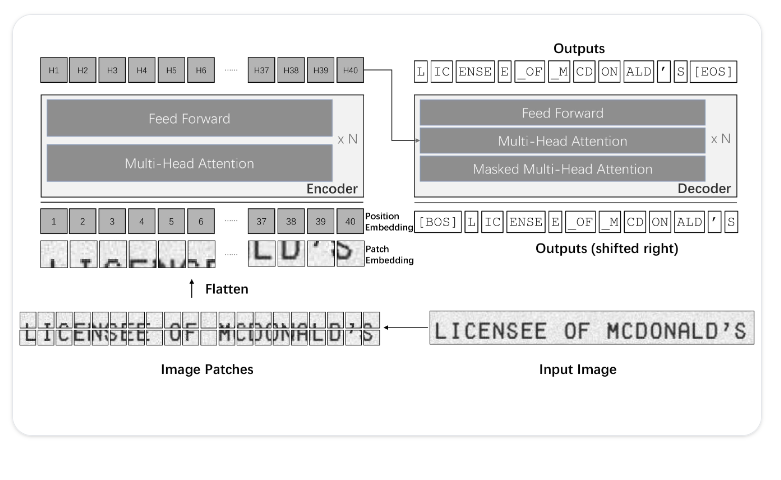

### Installing necssary packages

In [ ]:
!pip install transformers[torch] # transformers for TrOCR model
!pip install datasets jiwer # jiwer for model training

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 63.2 MB/s eta 0:00:00


## Import Libraries

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset
from PIL import Image
from datasets import load_metric

from transformers import TrOCRProcessor
from transformers import VisionEncoderDecoderModel
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
from transformers import default_data_collator

## Load the dataset

In [ ]:
# Connect to the google drive where dataset is stored.
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
# Load the IAM dataset into a Pandas DataFrame
df = pd.read_fwf('/content/drive/MyDrive/IAM/gt_test.txt',header=None)

#Setting column names
df.rename(columns={0:"file_name",1:"text"},inplace=True)

# Append jpg to each file name
del df[2]
df['file_name'] = df['file_name'].apply(lambda x: x + 'g' if x.endswith('jp') else x)
df.head()

,file_name,text
0,c04-110-00.jpg,Become a success with a disc and hey presto ! ...
1,c04-110-01.jpg,"assuredness "" Bella Bella Marie "" ( Parlophone..."
2,c04-110-02.jpg,I don't think he will storm the charts with th...
3,c04-110-03.jpg,"CHRIS CHARLES , 39 , who lives in Stockton-on-..."
4,c04-116-00.jpg,He is also a director of a couple of garages ....


In [ ]:
# Split the dataset into train and test set
train_df,test_df = train_test_split(df,test_size=0.2)

train_df.reset_index(drop=True,inplace=True)
test_df.reset_index(drop=True,inplace=True)

### Preprocessing the images

The preprocessing steps for each image are used before passing on the image to the OCR model for inference. The steps in image pre-processing
are implemented using OpenCV in Python.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image as im
from scipy.ndimage import interpolation as inter

def find_score(arr, angle):
    """
    Find skew projection score
    Parameters:
    -----------
    arr: histogram of pixels array
    angle: the angle at which the image is to be rotated

    Returns:
    ---------
    dst: the denoised image
    """
    data = inter.rotate(arr, angle, reshape=False, order=0)
    hist = np.sum(data, axis=1)
    score = np.sum((hist[1:] - hist[:-1]) ** 2)
    return hist, score

def skew_correction(img):
  """
  Remove noise from the image
  Parameters:
  -----------
  img: the skewed PIL image

  Returns:
  ---------
  img: the skew corrected image
  """
  wd, ht = img.size
  pix = np.array(img.convert('1').getdata(), np.uint8)
  bin_img = 1 - (pix.reshape((ht, wd)) / 255.0)
  delta = 1
  limit = 5
  angles = np.arange(-limit, limit+delta, delta)
  scores = []
  for angle in angles:
    hist, score = find_score(bin_img, angle)
    scores.append(score)
  best_score = max(scores)
  best_angle = angles[scores.index(best_score)]
  # correct skew
  data = inter.rotate(bin_img, best_angle, reshape=False, order=0)
  img = im.fromarray((255 * data).astype("uint8")).convert("RGB")
  return img

In [ ]:
import cv2
def noise_removal(img):
  """
  Remove noise from the image
  Parameters:
  -----------
  img: the noisy PIL image

  Returns:
  ---------
  dst: the denoised image
  """
  img_np = np.array(img)
  img = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)
  dst = cv2.fastNlMeansDenoisingColored(img, None, 10, 10, 7, 15)
  return dst

In [ ]:
def thinning(img):
  """
  Function to performa skeletonization / thinning on the image

  Parameters:
  ----------
  img: The PIL image to be thinned

  Returns:
  -------
  erosion: the thinned image
  """
  kernel = np.ones((5,5),np.uint8) # Define the kernel for the image skeletonization process
  erosion = cv2.erode(img,kernel,iterations = 1)
  return erosion

In [ ]:
# Create a class for handling the IAM dataset
class IAMDatasetPreprocessing(Dataset):
 def __init__(self,root_dir,df,processor,max_target_length=128):
  self.root_dir = root_dir
  self.df = df
  self.processor = processor
  self.max_target_length = max_target_length

 def __len__(self):
  """
  Helper function to return length of the dataset

  """
  return len(self.df)
 def __getitem__(self,idx):
  """
  Helper function to retrieve a particular data field in the dataset

  """
  file_name = self.df["file_name"][idx]
  text  = self.df["text"][idx]

  image = Image.open(self.root_dir + file_name).convert("RGB")
  image = thinning(noise_removal(skew_correction(image))) # Preprocessing the image
  pixel_values = self.processor(image,return_tensors="pt").pixel_values # Extracting pixel values for the image

  labels = self.processor.tokenizer(text,padding="max_length",max_length=self.max_target_length).input_ids

  labels = [label if label!=self.processor.tokenizer.pad_token_id else -100 for label in labels]

  encoding = {"pixel_values":pixel_values.squeeze(),"labels":torch.tensor(labels)}
  return encoding

### Base Handwritten TrOCR


Consists of BeIt Vision Encoder and RoBERTa Text Decoder

In [ ]:
# Load the trocr processor for tokenization and pre-processing for TroCR models for inference
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")

train_dataset = IAMDatasetPreprocessing(root_dir="/content/drive/MyDrive/IAM/image/",df=train_df,processor=processor)

eval_dataset = IAMDatasetPreprocessing(root_dir='/content/drive/MyDrive/IAM/image/',df=test_df,processor = processor )

preprocessor_config.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


tokenizer_config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

In [ ]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 2332
Number of validation examples: 583


In [ ]:
encoding  = train_dataset[2]
for k,v in encoding.items():
 print(k,v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([128])


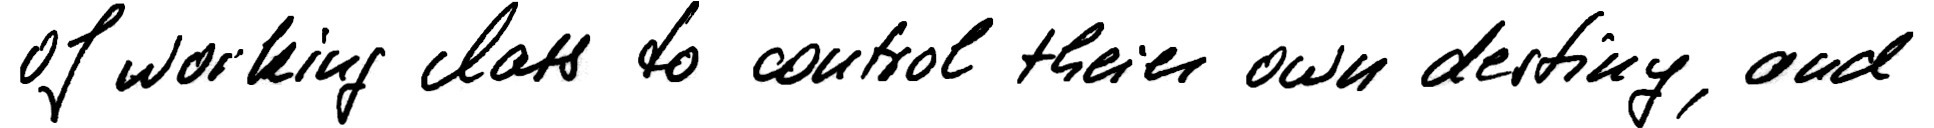

In [ ]:
# An example of a single image
image = Image.open(train_dataset.root_dir + train_df['file_name'][2]).convert("RGB")
image

In [ ]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

of the working class to control their own destiny, and


In [ ]:
# Download the pre-trained model with Beit Encoder and RoBerta decoder
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")

config.json:   0%|          | 0.00/4.17k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# Model Parameters

# Sets the token id for the start token of the text
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id

# Padding token id is set
model.config.pad_token_id = processor.tokenizer.pad_token_id

# Set the vocab size based on the decoder vocab size
model.config.vocab_size = model.config.decoder.vocab_size

# Set eos token id
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64 # Max length of text inferred by the model
model.config.early_stopping = True # Whether early stopping is done in optimization or not
model.config.no_repeat_ngram_size = 3 # Maximum size of repetitive ngrams

model.config.length_penalty = 2.0 # Beam search parameter
model.config.num_beams = 4


In [ ]:
# Sequence to sequence trainer
training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True, # prediction accompanied by generation
    evaluation_strategy="steps",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    fp16=True, #using 16-bit mixed precision
    output_dir="./",
    logging_steps=2,
    save_steps=1000,
    eval_steps=200,
)

### Define metric for training performance measure
The Character Error is the percentage of characters that have been transcribed incorrectly by the Text Recognition model. For example, a 5% CER means that the text model has automatically transcribed correctly 95 characters out of 100, while it has misread only 5 characters.A

In [ ]:
cer_metric = load_metric("cer",revision="master")


<ipython-input-22-ce3185c6ec7f>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  cer_metric = load_metric("cer",revision="master")


In [ ]:
def compute_metrics(pred):

  """
  Helper function to compute CER score for the OCR model

  """

  labels_ids = pred.label_ids
  pred_ids = pred.predictions

  pred_str = processor.batch_decode(pred_ids,skip_special_tokens = True)
  labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
  label_str = processor.batch_decode(labels_ids,skip_special_tokens=True)

  cer = cer_metric.compute(predictions=pred_str,references=label_str)
  return {"cer":cer}

In [ ]:
# instantiate trainer for base model
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/models/trocr/processing_trocr.py:135: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


Step,Training Loss,Validation Loss,Cer
200,1.441500,1.679012,0.205871
400,1.002200,0.918358,0.137522
600,0.126800,0.542760,0.067279
800,0.206000,0.427285,0.052291


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1473: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


TrainOutput(global_step=876, training_loss=0.8510560780321355, metrics={'train_runtime': 2647.1145, 'train_samples_per_second': 2.643, 'train_steps_per_second': 0.331, 'total_flos': 5.235003196207792e+18, 'train_loss': 0.8510560780321355, 'epoch': 3.0})

### TrOCR Model 2

 The image encoder was initialized from the weights of DeiT, while the text decoder was initialized from the weights of UniLM.

In [ ]:
# Download the pre-trained model with Deit Encoder and UniLM decoder
model_2 = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-small-handwritten")

config.json:   0%|          | 0.00/4.21k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/246M [00:00<?, ?B/s]

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-small-handwritten and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# Model Parameters

# Sets the token id for the start token of the text
model_2.config.decoder_start_token_id = processor.tokenizer.cls_token_id

# Padding token id is set
model_2.config.pad_token_id = processor.tokenizer.pad_token_id

# Set the vocab size based on the decoder vocab size
model_2.config.vocab_size = model_2.config.decoder.vocab_size

# Set eos token id
model_2.config.eos_token_id = processor.tokenizer.sep_token_id
model_2.config.max_length = 64 # Max length of text inferred by the model
model_2.config.early_stopping = True # Whether early stopping is done in optimization or not
model_2.config.no_repeat_ngram_size = 3 # Maximum size of repetitive ngrams

model_2.config.length_penalty = 2.0 # Beam search parameter
model_2.config.num_beams = 4

In [ ]:
# instantiate trainer for model 3
trainer = Seq2SeqTrainer(
    model=model_2,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/models/trocr/processing_trocr.py:135: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


Step,Training Loss,Validation Loss,Cer
200,6.955400,6.707717,0.791740
400,6.230100,6.482964,0.881047
600,6.216600,6.459922,0.747725
800,6.038000,6.415698,0.795776


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1473: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


TrainOutput(global_step=876, training_loss=6.535518993525745, metrics={'train_runtime': 476.6876, 'train_samples_per_second': 14.676, 'train_steps_per_second': 1.838, 'total_flos': 8.368943131860664e+17, 'train_loss': 6.535518993525745, 'epoch': 3.0})

## Model training 3

In [ ]:
# Download the pre-trained model with Vit Encoder and RoBERTa decoder
model_3 = VisionEncoderDecoderModel.from_pretrained("Saitomar/TrOCR-Vit-Roberta-bn-2")

In [ ]:
# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model_3,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/models/trocr/processing_trocr.py:135: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(
<ipython-input-30-9941a6f3f733>:7: DeprecationWarning: Please use `rotate` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  data = inter.rotate(arr, angle, reshape=False, order=0)
<ipython-input-30-9941a6f3f733>:26: DeprecationWarning: Please use `rotate` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  data = inter.rotate(bin_img, best_angle, reshape=False, order=0)


Step,Training Loss,Validation Loss,Cer
200,4.049300,4.465693,0.672209
400,2.952800,3.259503,0.549272
600,1.652100,2.448094,0.403325
800,1.443500,2.222555,0.365355


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1473: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


TrainOutput(global_step=876, training_loss=3.0609387592093587, metrics={'train_runtime': 8963.4391, 'train_samples_per_second': 0.781, 'train_steps_per_second': 0.098, 'total_flos': 5.235003196207792e+18, 'train_loss': 3.0609387592093587, 'epoch': 3.0})